### Analysis of Buttons Bandit

In [1]:
# Run this script to add the src directory to the python path

from notebook_utils import modify_sys_path, get_src_dir_path

modify_sys_path()

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import re

from src.bandit import ButtonsBandit

In [23]:
# results_directory = 'results/logistic_regression_3/experiment_2/active_learning/dataset_specified/'

results_directory = 'results/bandits/buttons/initial_tuning/'
run_name = "exp_20_seed_1.csv"

In [24]:
D_data = None

for filename in os.listdir(get_src_dir_path(results_directory)):
    if f"D_{run_name}" in filename:
        D_data = pd.read_csv(get_src_dir_path(results_directory) + filename)

In [25]:
# Compute cumulative label

D_data['cum_reward'] = D_data['label'].cumsum()
D_data['cum_regret'] = D_data['regret'].cumsum()

Text(0.5, 1.0, 'Cumulative Reward over Trials')

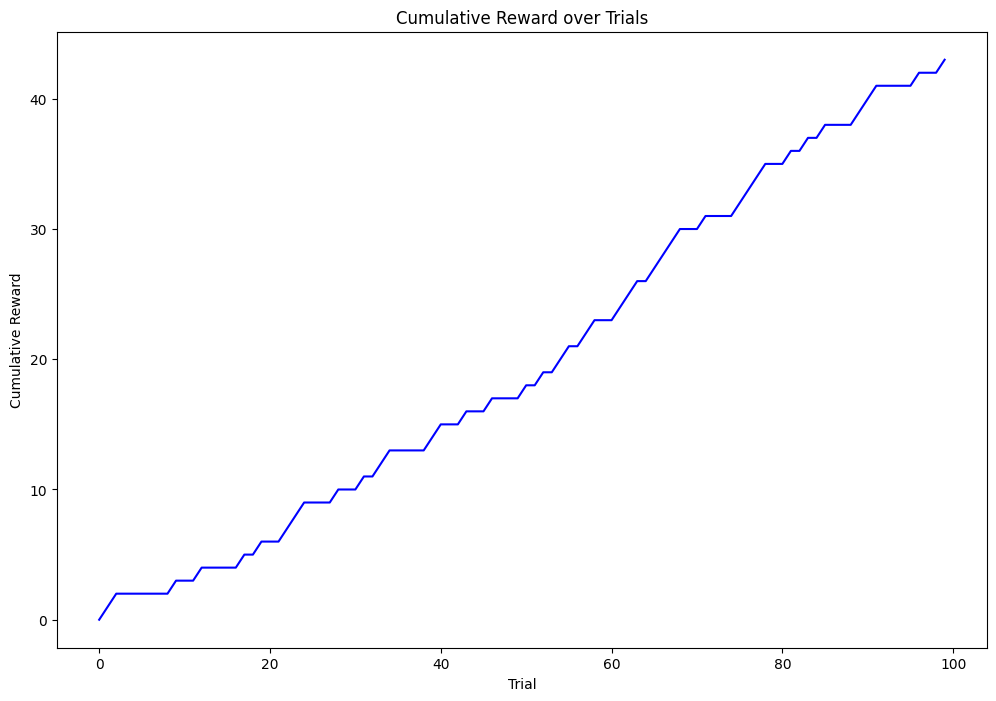

In [26]:
# plot cumulative reward against trials
plt.figure(figsize=(12, 8))
plt.plot(D_data['trial'], D_data['cum_reward'], label='Cumulative Reward', color='blue')
plt.xlabel('Trial')
plt.ylabel('Cumulative Reward')
plt.title('Cumulative Reward over Trials')

Text(0.5, 1.0, 'Cumulative Regret over Trials')

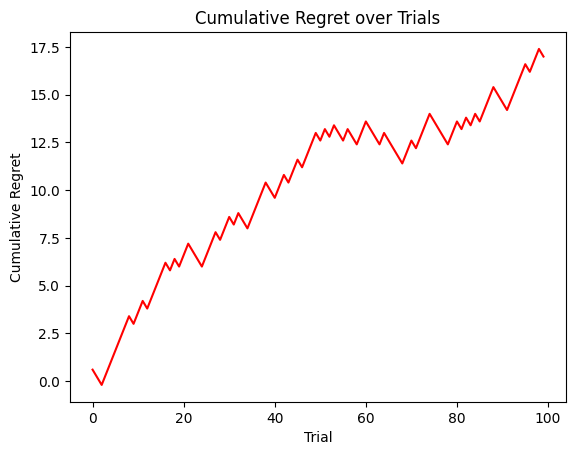

In [27]:
plt.plot(D_data['trial'], D_data['cum_regret'], label='Cumulative Regret', color='red')
plt.xlabel('Trial')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret over Trials')

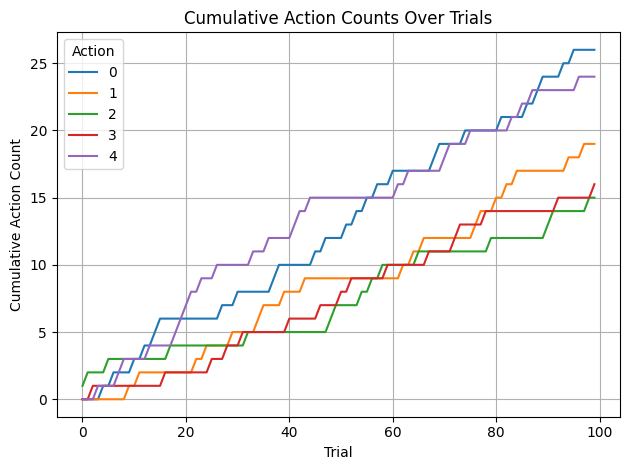

In [28]:
# Plot action counts over trials for each arm

action_counts = D_data.groupby(['trial', 'action']).size().unstack(fill_value=0)

# Sort by trial to ensure proper cumulative sum
action_counts = action_counts.sort_index()

# Cumulative sum over trials
cumulative_counts = action_counts.cumsum()

# Plot cumulative action counts
cumulative_counts.plot()
plt.xlabel('Trial')
plt.ylabel('Cumulative Action Count')
plt.title('Cumulative Action Counts Over Trials')
plt.legend(title='Action')
plt.tight_layout()
plt.grid()
plt.show()

In [29]:
mean_reward = D_data["label"].mean()
median_reward = D_data["label"].median()

print(f"Mean reward: {mean_reward}")
print(f"Median reward: {median_reward}")

Mean reward: 0.43
Median reward: 0.0


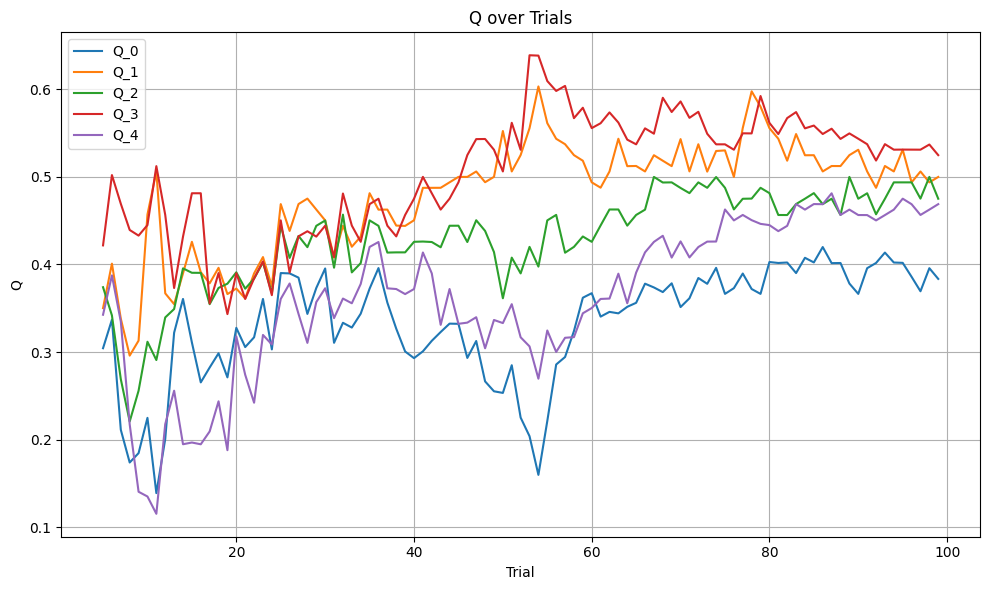

In [30]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(D_data['trial'], D_data[f'Q_value_{i}'], label=f'Q_{i}')

plt.xlabel('Trial')
plt.ylabel('Q')
plt.title('Q over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

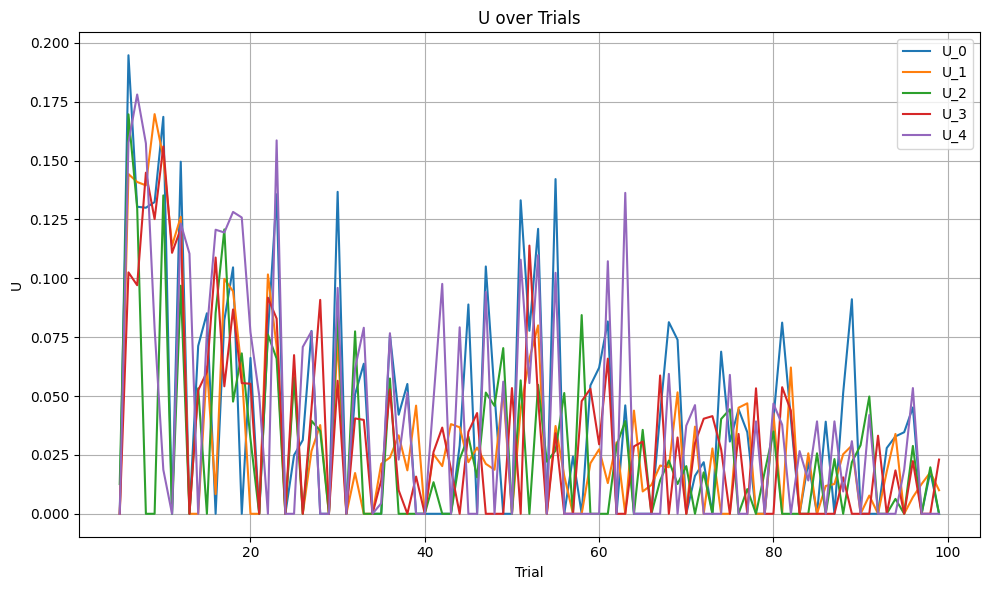

In [31]:
plt.figure(figsize=(10, 6))
for i in range(5):
    plt.plot(D_data['trial'], D_data[f'U_value_{i}'], label=f'U_{i}')

plt.xlabel('Trial')
plt.ylabel('U')
plt.title('U over Trials')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='action'>

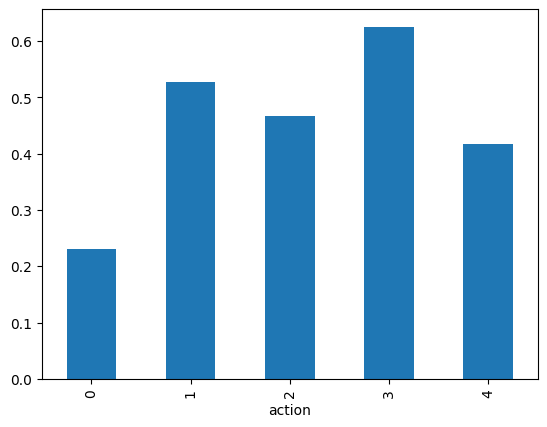

In [32]:
D_data.groupby('action')['label'].mean().plot(kind='bar')